<h2>Importing Modules</h2>

In [26]:
import pandas as pd
import os
import numpy as np
import re
from wordcloud import WordCloud
import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from pprint import pprint
import pyLDAvis.gensim
import pickle 
import pyLDAvis

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<h2>Loading Data</h2>

In [8]:
os.chdir('..')
train = pd.read_csv("D:\\DEVELOPEMENT\\Kaggle Contest\\AES-Kaggle\\Main\\input_data\\train.csv")

train.head()

,essay_id,full_text,score
0,000d118,Many people have car where they live. The thin...,3
1,000fe60,I am a scientist at NASA that is discussing th...,3
2,001ab80,People always wish they had the same technolog...,4
3,001bdc0,"We all heard about Venus, the planet without a...",4
4,002ba53,"Dear, State Senator\r\n\r\nThis is a letter to...",3


<h2>Data Cleaning</h2>

In [9]:
train = train.drop(columns=["essay_id"], axis=1)
train.head()

,full_text,score
0,Many people have car where they live. The thin...,3
1,I am a scientist at NASA that is discussing th...,3
2,People always wish they had the same technolog...,4
3,"We all heard about Venus, the planet without a...",4
4,"Dear, State Senator\r\n\r\nThis is a letter to...",3


In [13]:
train['full_text_processed'] = train['full_text'].map(lambda x: re.sub('[,\.!?]', '', x))
train['full_text_processed']=train['full_text_processed'].map(lambda x: x.lower())

train['full_text_processed'].head()



0    many people have car where they live the thing...
1    i am a scientist at nasa that is discussing th...
2    people always wish they had the same technolog...
3    we all heard about venus the planet without al...
4    dear state senator\r\n\r\nthis is a letter to ...
Name: full_text_processed, dtype: object

<h2>Exploratory Analysis</h2>

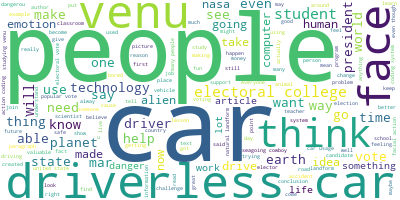

In [17]:
long_string = ','.join(list(train['full_text_processed'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

<h2>Preparing data for LDA analysis</h2>

In [21]:
stop_words = stopwords.words('english')
# we need to add some more stopwords =>
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

def sent_to_words(sentences):
    # function to convert sentences to words
    # deacc removes punctuations
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    # Function to stop stopwords
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

data = train.full_text_processed.values.tolist()

data_words = list(sent_to_words(data))
data_words = remove_stopwords(data_words)

print(data_words[:1][0][:30])

['many', 'people', 'car', 'live', 'thing', 'know', 'car', 'alot', 'thing', 'happen', 'like', 'get', 'accidet', 'smoke', 'car', 'bad', 'breath', 'someone', 'walk', 'vaubangermany', 'dont', 'proble', 'percent', 'vauban', 'families', 'carsand', 'percent', 'sold', 'car', 'move']


In [23]:
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
# Each tuple represents a word in the document along with its frequency.
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 3), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 2), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 2), (22, 14), (23, 3), (24, 2), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1)]


<h3>LDA model training</h3>

In [25]:
# Number of topics = 10
num_topics = 5

# Build LDA Model
lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=num_topics)

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.014*"would" + 0.013*"people" + 0.011*"venus" + 0.010*"could" + '
  '0.009*"electoral" + 0.008*"college" + 0.007*"planet" + 0.007*"like" + '
  '0.007*"cars" + 0.006*"car"'),
 (1,
  '0.014*"people" + 0.013*"would" + 0.010*"venus" + 0.010*"cars" + '
  '0.009*"like" + 0.008*"car" + 0.008*"face" + 0.007*"also" + 0.007*"vote" + '
  '0.006*"could"'),
 (2,
  '0.020*"cars" + 0.016*"car" + 0.016*"venus" + 0.013*"would" + 0.011*"people" '
  '+ 0.009*"driverless" + 0.009*"could" + 0.008*"like" + 0.008*"also" + '
  '0.006*"face"'),
 (3,
  '0.015*"people" + 0.013*"could" + 0.012*"would" + 0.010*"car" + 0.009*"like" '
  '+ 0.008*"venus" + 0.008*"help" + 0.007*"get" + 0.006*"also" + 0.006*"cars"'),
 (4,
  '0.017*"cars" + 0.017*"would" + 0.017*"car" + 0.012*"driverless" + '
  '0.010*"people" + 0.008*"think" + 0.007*"face" + 0.007*"could" + '
  '0.007*"like" + 0.006*"many"')]


<h3>Analyzing LDA model results</h3>

In [28]:
# Visualize the topics
pyLDAvis.enable_notebook()

file_name = str(num_topics) +'.html'
LDAvis_data_filepath = os.path.join('D:\\DEVELOPEMENT\\Kaggle Contest\\AES-Kaggle\\Main\\topic_evaluation\\result_data\\ldavis_prepared_' + str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, 'D:\\DEVELOPEMENT\\Kaggle Contest\\AES-Kaggle\\Main\\topic_evaluation\\result_data\\ldavis_prepared_'+ file_name)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.017090 -0.005966       1        1  25.356350
0     -0.014579  0.005247       2        1  23.691655
2      0.011952  0.007195       3        1  22.812766
3     -0.011101 -0.009133       4        1  15.783029
1     -0.003362  0.002657       5        1  12.356200, topic_info=           Term          Freq         Total Category  logprob  loglift
23         cars  39686.000000  39686.000000  Default  30.0000  30.0000
281  driverless  20474.000000  20474.000000  Default  29.0000  29.0000
99       people  38790.000000  38790.000000  Default  28.0000  28.0000
498       venus  32572.000000  32572.000000  Default  27.0000  27.0000
532   electoral  16413.000000  16413.000000  Default  26.0000  26.0000
..          ...           ...           ...      ...      ...      ...
522     college   1572.638670  14119.274767   Topic5  -5.5178  -0.1038
143       think   1726.111582  17403.116398   Topic5  -5.4247  -0.2198
210      planet   1549.825006  14193.605730   Topic5  -5.5324  -0.1236
90          new   1374.871757  11164.996108   Topic5  -5.6522  -0.0034
66         help   1444.357321  15523.462634   Topic5  -5.6029  -0.2837

[467 rows x 6 columns], token_table=       Topic      Freq    Term
term                          
37155      2  0.433881   abdut
239        1  0.316529    able
239        2  0.267220    able
239        3  0.170794    able
239        4  0.144811    able
...      ...       ...     ...
3332       3  0.278234  wrecks
3332       4  0.079952  wrecks
3332       5  0.063962  wrecks
46881      1  0.832739     yha
35175      2  0.434981    yhat

[1080 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 3, 4, 2])